<a href="https://colab.research.google.com/github/shcho11/00.Projects_KoreaUniv_2023-1/blob/main/202306_ARIMAvsLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아파트매매가격지수 예측 ARIMA모델과 LSTM 모델 비교 구현
- 작성 : 조송현

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
os.getcwd()

'/content'

In [ ]:
df = pd.read_excel('drive/MyDrive/202301_DV/dataset_realestateprice.xlsx')
df.head()

,시점,아파트매매가격지수,신규취급액기준 COFIX,잔액기준 COFIX,소비자물가지수,"M2(평잔, 원계열)",광공업지수,아파트전세가격지수,만기2년미만정기예적금,매출어음,주거용건물공사비지수,생산자물가지수,국내건설수주액민간,전국미분양현황,실업률,경제활동인구 (천명),경제활동참가율 (%)
0,2013.09,79.1,2.63,2.99,93.419,1903187.1,87.899,78.8,874185.2,1311.8,97.98,104.71,45096,66110,2.7,26422,62.3
1,2013.10,79.5,2.62,2.94,93.134,1908557.6,98.506,79.6,876568.9,1326.0,97.94,104.34,70827,64433,2.7,26522,62.5
2,2013.11,79.7,2.60,2.91,93.116,1923339.2,97.550,80.2,876987.6,1331.1,97.81,104.13,50211,63709,2.6,26497,62.4
3,2013.12,79.9,2.66,2.88,93.229,1932026.4,98.593,80.7,872483.1,1373.6,98.06,104.37,63647,61091,3.0,26023,61.2
4,2014.01,80.2,2.64,2.86,93.730,1937045.6,92.594,81.4,869324.6,1367.8,98.46,104.65,36162,58576,3.4,25941,60.9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   시점             73 non-null     float64
 1   아파트매매가격지수      73 non-null     float64
 2   신규취급액기준 COFIX  73 non-null     float64
 3   잔액기준 COFIX     73 non-null     float64
 4   소비자물가지수        73 non-null     float64
 5   M2(평잔, 원계열)    73 non-null     float64
 6   광공업지수          73 non-null     float64
 7   아파트전세가격지수      73 non-null     float64
 8   만기2년미만정기예적금    73 non-null     float64
 9   매출어음           73 non-null     float64
 10  주거용건물공사비지수     73 non-null     float64
 11  생산자물가지수        73 non-null     float64
 12  국내건설수주액민간      73 non-null     int64  
 13  전국미분양현황        73 non-null     int64  
 14  실업률            73 non-null     float64
 15  경제활동인구 (천명)    73 non-null     int64  
 16  경제활동참가율 (%)    73 non-null     float64
dtypes: float64(14), int64(3)
memory usage: 9.8 KB


In [ ]:
df.isnull().sum()

시점               0
아파트매매가격지수        0
신규취급액기준 COFIX    0
잔액기준 COFIX       0
소비자물가지수          0
M2(평잔, 원계열)      0
광공업지수            0
아파트전세가격지수        0
만기2년미만정기예적금      0
매출어음             0
주거용건물공사비지수       0
생산자물가지수          0
국내건설수주액민간        0
전국미분양현황          0
실업률              0
경제활동인구 (천명)      0
경제활동참가율 (%)      0
dtype: int64

In [ ]:
# 컬럼명 바꿔주기

asis_cols = df.columns.tolist()
tobe_cols = ['time','price','cofix_new','cofix_res','cpi','m2','idx_manuf','jeonse','savings','promissory','const_cost','ppi','contract','unsold','unemploy','active_num','active_rate']

for i in range(len(asis_cols)) :
  df.rename(columns={asis_cols[i] : tobe_cols[i]}, inplace=True)

In [ ]:
df.head(3)

,time,price,cofix_new,cofix_res,cpi,m2,idx_manuf,jeonse,savings,promissory,const_cost,ppi,contract,unsold,unemploy,active_num,active_rate
0,2013.09,79.1,2.63,2.99,93.419,1903187.1,87.899,78.8,874185.2,1311.8,97.98,104.71,45096,66110,2.7,26422,62.3
1,2013.10,79.5,2.62,2.94,93.134,1908557.6,98.506,79.6,876568.9,1326.0,97.94,104.34,70827,64433,2.7,26522,62.5
2,2013.11,79.7,2.60,2.91,93.116,1923339.2,97.550,80.2,876987.6,1331.1,97.81,104.13,50211,63709,2.6,26497,62.4


In [ ]:
# time 컬럼 자료형 바꿔주기 float -> object(strftime)
df['time'] = pd.to_datetime(df.time.astype(str), format='%Y.%m').dt.strftime('%Y-%m')
df.head()

,time,price,cofix_new,cofix_res,cpi,m2,idx_manuf,jeonse,savings,promissory,const_cost,ppi,contract,unsold,unemploy,active_num,active_rate
0,2013-09,79.1,2.63,2.99,93.419,1903187.1,87.899,78.8,874185.2,1311.8,97.98,104.71,45096,66110,2.7,26422,62.3
1,2013-01,79.5,2.62,2.94,93.134,1908557.6,98.506,79.6,876568.9,1326.0,97.94,104.34,70827,64433,2.7,26522,62.5
2,2013-11,79.7,2.60,2.91,93.116,1923339.2,97.550,80.2,876987.6,1331.1,97.81,104.13,50211,63709,2.6,26497,62.4
3,2013-12,79.9,2.66,2.88,93.229,1932026.4,98.593,80.7,872483.1,1373.6,98.06,104.37,63647,61091,3.0,26023,61.2
4,2014-01,80.2,2.64,2.86,93.730,1937045.6,92.594,81.4,869324.6,1367.8,98.46,104.65,36162,58576,3.4,25941,60.9


In [ ]:
# 10월이 01월로 변환되는 것 정정

rep_start = 1
rep_stop = len(df)
rep_step = 12
rep_col = 0

for i in range(rep_start, rep_stop, rep_step) :
  df.iloc[i,rep_col] = df.iloc[i,rep_col].replace('-01', '-10')

In [ ]:
df.head(3)

,time,price,cofix_new,cofix_res,cpi,m2,idx_manuf,jeonse,savings,promissory,const_cost,ppi,contract,unsold,unemploy,active_num,active_rate
0,2013-09,79.1,2.63,2.99,93.419,1903187.1,87.899,78.8,874185.2,1311.8,97.98,104.71,45096,66110,2.7,26422,62.3
1,2013-10,79.5,2.62,2.94,93.134,1908557.6,98.506,79.6,876568.9,1326.0,97.94,104.34,70827,64433,2.7,26522,62.5
2,2013-11,79.7,2.60,2.91,93.116,1923339.2,97.550,80.2,876987.6,1331.1,97.81,104.13,50211,63709,2.6,26497,62.4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         73 non-null     object 
 1   price        73 non-null     float64
 2   cofix_new    73 non-null     float64
 3   cofix_res    73 non-null     float64
 4   cpi          73 non-null     float64
 5   m2           73 non-null     float64
 6   idx_manuf    73 non-null     float64
 7   jeonse       73 non-null     float64
 8   savings      73 non-null     float64
 9   promissory   73 non-null     float64
 10  const_cost   73 non-null     float64
 11  ppi          73 non-null     float64
 12  contract     73 non-null     int64  
 13  unsold       73 non-null     int64  
 14  unemploy     73 non-null     float64
 15  active_num   73 non-null     int64  
 16  active_rate  73 non-null     float64
dtypes: float64(13), int64(3), object(1)
memory usage: 9.8+ KB


In [ ]:
df1 =  df.copy()

## EDA

Text(0.5, 1.0, 'Correlation between the Variables')

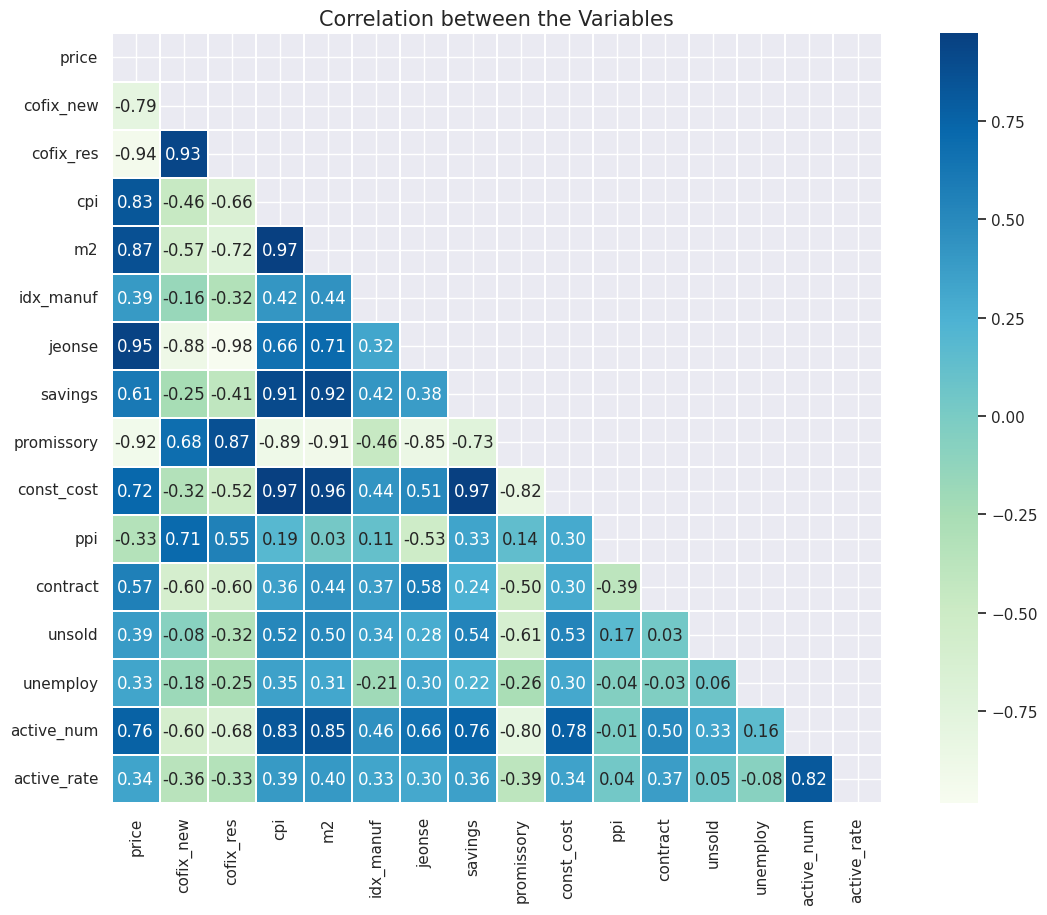

In [ ]:
import seaborn as sns
corr = df1.corr()

sns.set(rc = {'figure.figsize':(15,10)})
mask = np.zeros_like(corr, dtype=np.bool) # to plot only part of a matrix
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            annot = True, # write the value in each cell
            cmap = 'GnBu',
            square = True, # set the axes aspect to "equal"
            mask = mask,
            linewidths=0.2,
            fmt='.2f')
plt.title('Correlation between the Variables', fontsize=15)


In [ ]:
# Drop features having high colinearity with other similar ones

dropcols= ['cofix_res','m2','const_cost','savings']
df1_1 = df1.drop(columns=dropcols)
df1_1

,time,price,cofix_new,cpi,idx_manuf,jeonse,promissory,ppi,contract,unsold,unemploy,active_num,active_rate
0,2013-09,79.1,2.63,93.419,87.899,78.8,1311.8,104.71,45096,66110,2.7,26422,62.3
1,2013-10,79.5,2.62,93.134,98.506,79.6,1326.0,104.34,70827,64433,2.7,26522,62.5
2,2013-11,79.7,2.60,93.116,97.550,80.2,1331.1,104.13,50211,63709,2.6,26497,62.4
3,2013-12,79.9,2.66,93.229,98.593,80.7,1373.6,104.37,63647,61091,3.0,26023,61.2
4,2014-01,80.2,2.64,93.730,92.594,81.4,1367.8,104.65,36162,58576,3.4,25941,60.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2019-05,86.4,1.85,99.652,102.068,88.8,312.7,103.79,86254,62741,4.0,28468,64.0
69,2019-06,86.2,1.78,99.491,99.342,88.5,313.0,103.50,94380,63705,4.0,28545,64.2
70,2019-07,86.0,1.68,99.187,103.947,88.3,312.9,103.50,76455,62529,3.9,28480,64.0
71,2019-08,85.8,1.52,99.425,97.086,88.1,299.6,103.74,61174,62385,3.0,28216,63.3


Text(0.5, 1.0, 'Correlation between the Variables (after cleansing)')

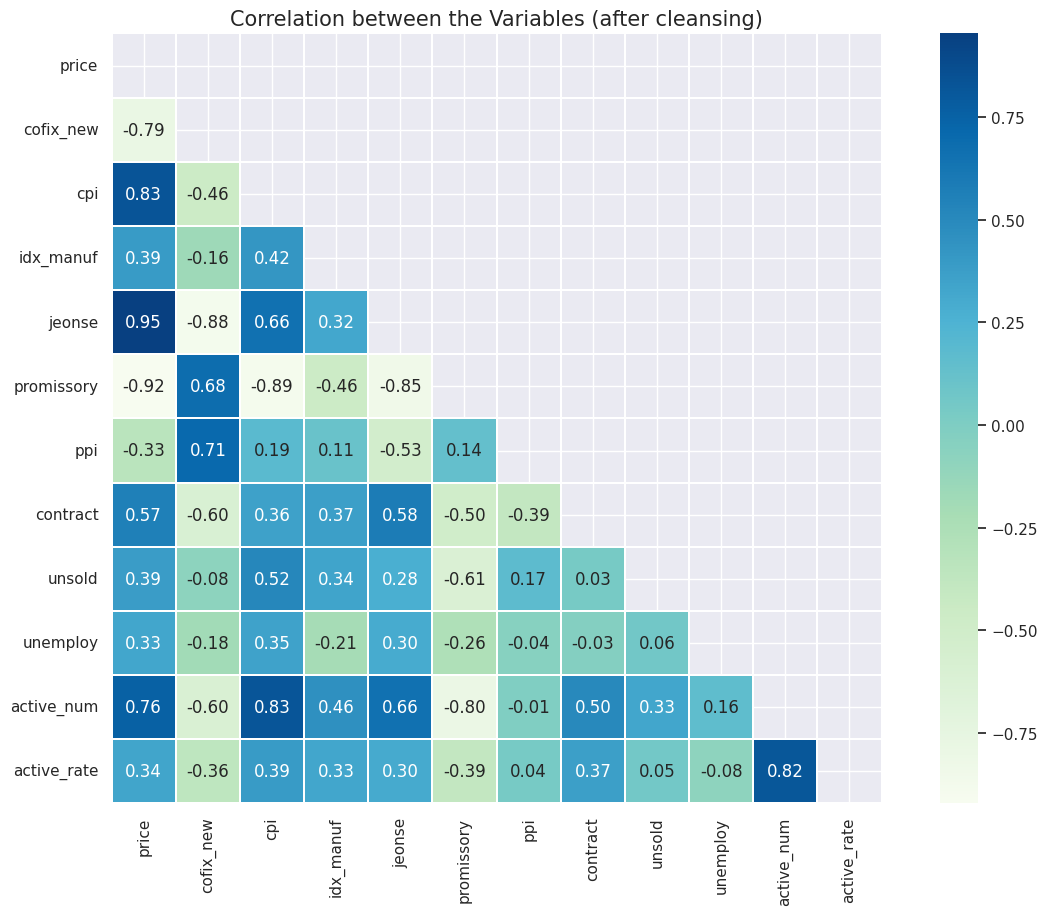

In [ ]:
import seaborn as sns
corr1 = df1_1.corr()

sns.set(rc = {'figure.figsize':(15,10)})
mask1 = np.zeros_like(corr1, dtype=np.bool) # to plot only part of a matrix
mask1[np.triu_indices_from(mask1)] = True

sns.heatmap(corr1,
            annot = True, # write the value in each cell
            cmap = 'GnBu',
            square = True, # set the axes aspect to "equal"
            mask = mask1,
            linewidths=0.2,
            fmt='.2f')
plt.rc('font', family='NanumBarunGothic')
plt.title('Correlation between the Variables (after cleansing)', fontsize=15)

In [ ]:
# 논문 Dataset (use 5 features as presented by the paper below)
# https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002476446
dfvf1 = df1[['time','price','cofix_new','cpi','m2','idx_manuf','jeonse']]

# My Dataset (use more features compared to the upper dataset)
dfvf2 = df1_1.copy()

In [ ]:
print(df1_1.shape)

(73, 13)


## 1. ARIMA 모델
- p,d,q 결정하기
  - For ARIMA models, a standard notation would be ARIMA with p, d, and q, where integer values substitute for the parameters to indicate the type of ARIMA model used.

- p: the number of lag observations in the model; also known as the lag order.
- d: the number of times that the raw observations are differenced; also known as the degree of differencing.
- q: the size of the moving average window; also known as the order of the moving average.


In [ ]:
df_arima = df1[['time','price']]
df_arima.set_index('time', inplace=True)

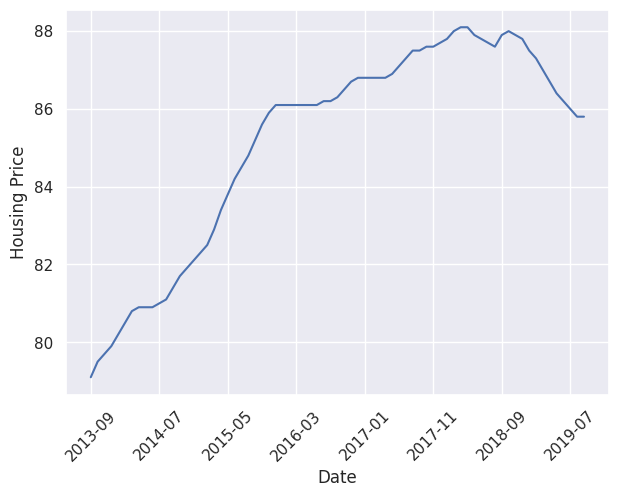

In [ ]:
plt.figure(figsize=(7,5))
df_arima['price'].plot()
plt.xlabel('Date')
plt.ylabel('Housing Price')
plt.xticks(rotation=45)
plt.show()

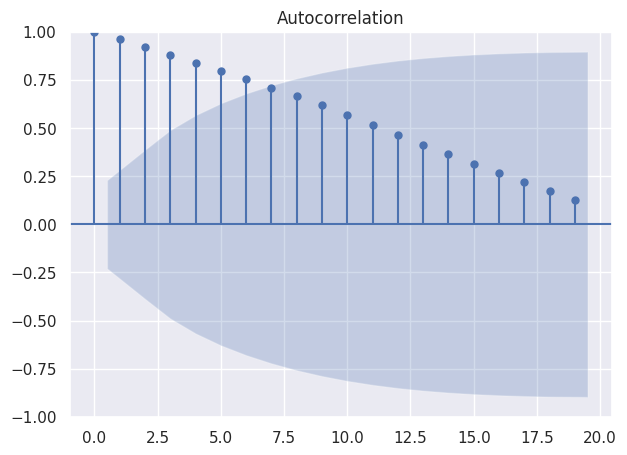

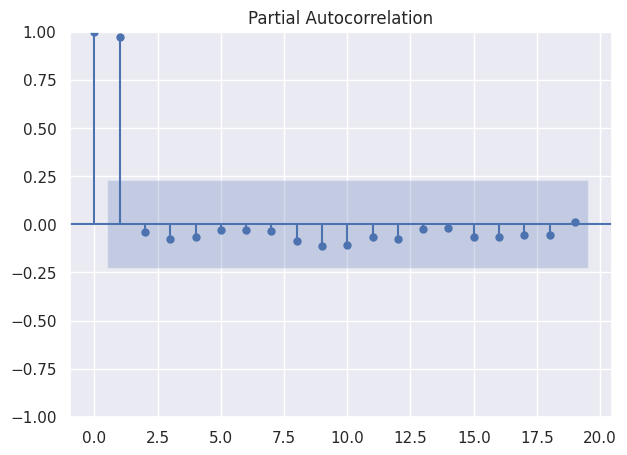

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams["figure.figsize"] = (7,5)
plot_acf(df_arima)
plot_pacf(df_arima)
plt.show()

## 차분 (differencing)
- 1차 차분

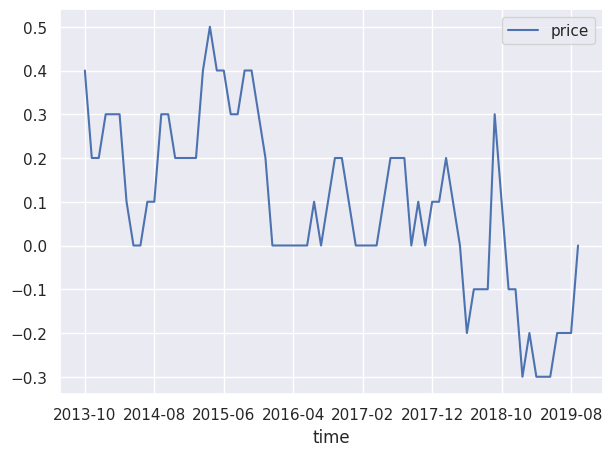

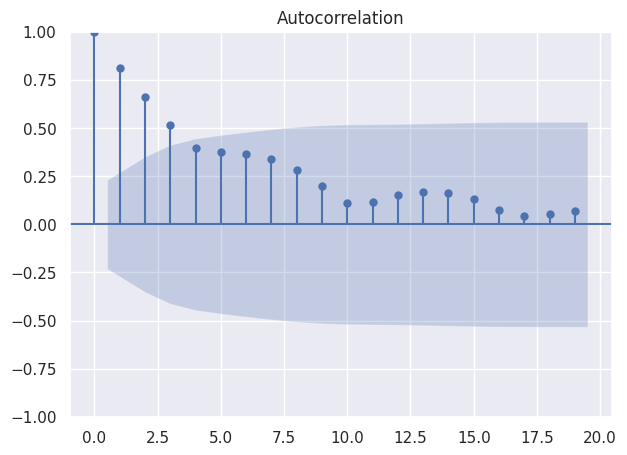

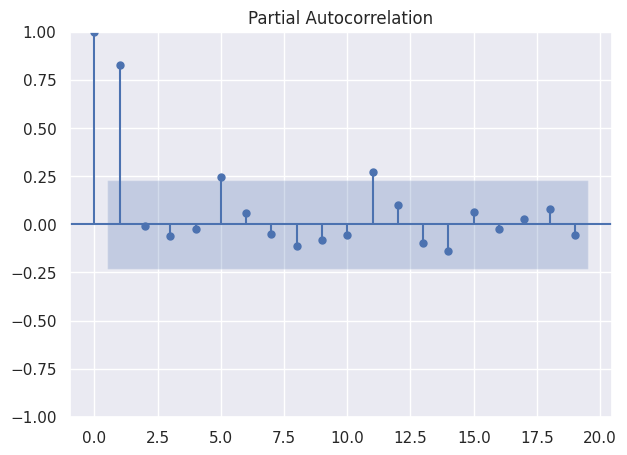

In [ ]:
diff_1 = df_arima.diff(periods=1)[1:]

plt.rcParams["figure.figsize"] = (7,5)
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

- 1차 차분 결과, 여전히 정상성을 확보했다고 보기 힘들다
- 2차 차분을 해 본다

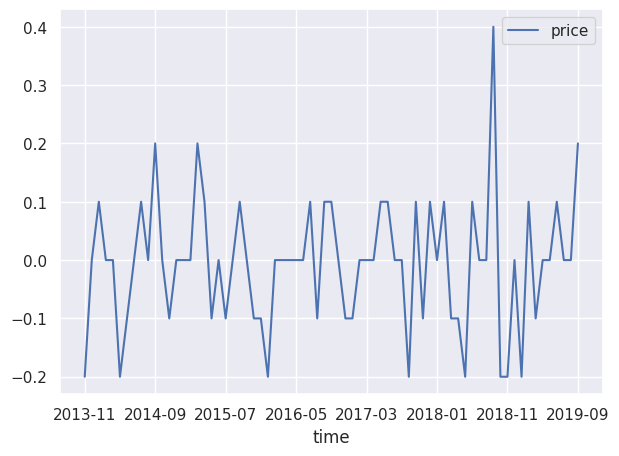

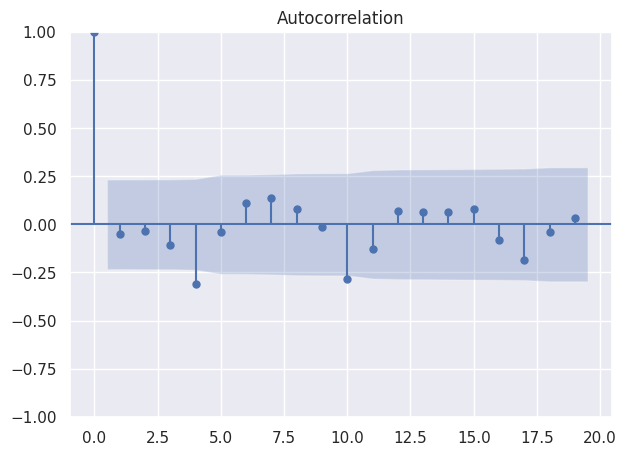

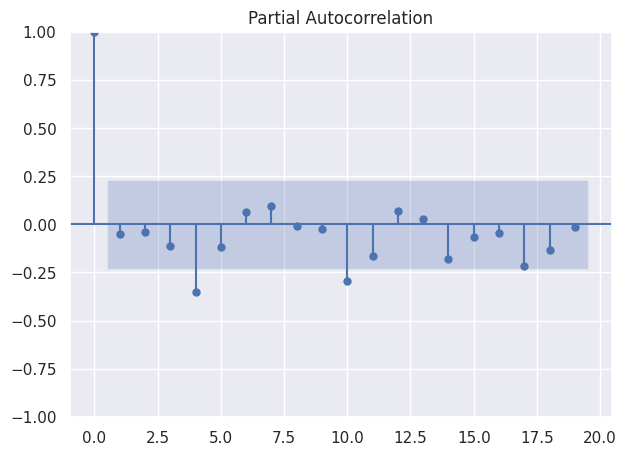

In [ ]:
# 2차 차분
diff_2 = diff_1.diff(periods=1)[1:]

diff_2.plot()
plot_acf(diff_2)
plot_pacf(diff_2)
plt.show()

### 2차 차분 결과
- 2차 차분한 상태에서 ACF, PACF 그래프를 보면 공통적으로 lag2 부터 자기상관값이 boundary 안으로 들어오는 것으로 보아 정상성 확보
- 육안으로는 ACF가 lag2에서 절단점(q=1) , PACF가 lag2에서 절단점(p=1) 확인되나 grid search를 진행하여 minimum AIC score으로 최적의 p,d,q를 찾아본다

## (ARIMA) Data Split

In [ ]:
df_arima.head()

,price
time,
2013-09,79.1
2013-10,79.5
2013-11,79.7
2013-12,79.9
2014-01,80.2


In [ ]:
print(round(73*0.2, 1))

14.6


In [ ]:
# Dataset 73개의 20%(약 15개)를 테스트셋, 나머지(58개)를 훈련셋으로 설정.

train_data = df_arima[:len(df_arima)-15]
test_data = df_arima[len(df_arima)-15:]

In [ ]:
print(df_arima.shape, "\n", train_data.shape, test_data.shape)

(73, 1) 
 (58, 1) (15, 1)


In [ ]:
display(train_data.head(3))
display(test_data.head(3))

,price
time,
2013-09,79.1
2013-10,79.5
2013-11,79.7


,price
time,
2018-07,87.7
2018-08,87.6
2018-09,87.9


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm

p = range(0,3) # p:0,1,2
d = range(1,3) # d:1,2
q = range(0,3) # q:0,1,2

pdq = list(itertools.product(p,d,q))

aic = []
params = []

with tqdm(total = len(pdq)) as pg:
    for i in pdq:
        pg.update(1)
        try:
            model = ARIMA(train_data['price'], order=(i))
            model_fit = model.fit()
            aic.append(round(model_fit.aic,2))
            params.append((i))
        except:
            continue

100%|██████████| 18/18 [00:06<00:00,  2.79it/s]


In [ ]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = ARIMA(train_data['price'], order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   58
Model:                 ARIMA(2, 2, 2)   Log Likelihood                  58.349
Date:                Sat, 10 Jun 2023   AIC                           -106.697
Time:                        09:03:50   BIC                            -96.571
Sample:                    09-01-2013   HQIC                          -102.771
                         - 06-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1794      0.021     57.264      0.000       1.139       1.220
ar.L2         -0.9984      0.016    -63.200      0.000      -1.029      -0.967
ma.L1         -1.1910      0.262     -4.550      0.000      -1.704      -0.678
ma.L2          0.9783      0.365      2.682      0.007       0.263       1.693
sigma2         0.0068      0.002      2.997      0.003       0.002       0.011
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.30   Prob(JB):                         0.78
Heteroskedasticity (H):               1.13   Skew:                            -0.06
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- aic가 가장 낮은 p,d,q = (2,2,2) 조합으로 설정

In [ ]:
arima_pred = model_opt_fit.predict(start = len(train_data), end = len(df_arima)-1, typ="levels").rename("ARIMA Predictions")

new_axis = test_data.index.tolist()
arima_pred = arima_pred.set_axis(new_axis, axis='index')
arima_pred

2018-07    87.771918
2018-08    87.779049
2018-09    87.755902
2018-10    87.661889
2018-11    87.514527
2018-12    87.375006
2019-01    87.297996
2019-02    87.286882
2019-03    87.291070
2019-04    87.247511
2019-05    87.132361
2019-06    86.980454
2019-07    86.856674
2019-08    86.802767
2019-09    86.803184
Name: ARIMA Predictions, dtype: float64

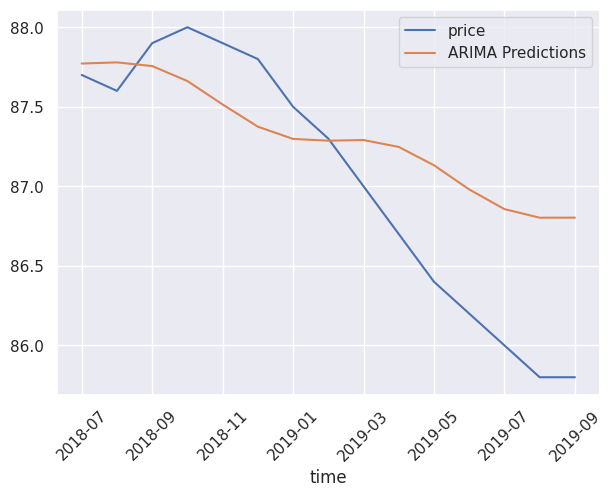

In [ ]:
#test_data1 = test_data.set_index('time')

test_data['price'].plot(figsize = (7,5), legend=True)
arima_pred.plot(legend = True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
test_data['ARIMA_Predictions'] = arima_pred

In [ ]:
test_data.head()

,price,ARIMA_Predictions
time,,
2018-07,87.7,87.771918
2018-08,87.6,87.779049
2018-09,87.9,87.755902
2018-10,88.0,87.661889
2018-11,87.9,87.514527


In [ ]:
arima_rmse = mean_squared_error(test_data['price'], test_data['ARIMA_Predictions'])**0.5
arima_mse = arima_rmse**2

print(f'ARIMA MSE Error: {arima_mse} \nARIMA RMSE Error: {arima_rmse}')

ARIMA MSE Error: 0.3212176633214833 
ARIMA RMSE Error: 0.5667606755249374


## 2-1. LSTM (Paper)

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
import tensorflow as tf
import sys
import google.protobuf
import h5py
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [ ]:
# shap이 tf2 버전에서 지원되지 않는 문제 해결하기 위함.

from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# 논문 Dataset (use 5 features as presented by the paper below)
# https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002476446
dfvf1 = df1[['time','price','cofix_new','cpi','m2','idx_manuf','jeonse']]

In [ ]:
dfvf1 = dfvf1.set_index('time')
dfvf1.head()

,price,cofix_new,cpi,m2,idx_manuf,jeonse
time,,,,,,
2013-09,79.1,2.63,93.419,1903187.1,87.899,78.8
2013-10,79.5,2.62,93.134,1908557.6,98.506,79.6
2013-11,79.7,2.60,93.116,1923339.2,97.550,80.2
2013-12,79.9,2.66,93.229,1932026.4,98.593,80.7
2014-01,80.2,2.64,93.730,1937045.6,92.594,81.4


In [ ]:
# Split the data into training and testing sets
train_data1 = dfvf1[:len(dfvf1)-15]

# LSTM모델에서 t-1 시점 변수를 가져오기 위해 아래와 같이 split
test_data1 = dfvf1[len(dfvf1)-16:]

In [ ]:
test_data1.head()

,price,cofix_new,cpi,m2,idx_manuf,jeonse
time,,,,,,
2018-06,87.8,1.84,98.779,2622268.3,101.222,91.5
2018-07,87.7,1.81,98.590,2637421.8,101.880,91.2
2018-08,87.6,1.80,99.462,2651503.4,99.154,90.9
2018-09,87.9,1.83,100.221,2652829.5,96.147,90.8
2018-10,88.0,1.93,100.041,2674506.5,105.733,90.7


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(train_data1)
scaled_train_data1 = scaler.transform(train_data1)

In [ ]:
scaler.fit(test_data1)
scaled_test_data1 = scaler.transform(test_data1)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()

  # input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

  # forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

  # put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names

  # drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
train_f = series_to_supervised(scaled_train_data1, 1, 1)
train_f.drop(train_f.columns[(dfvf1.shape[1]+1):], axis=1, inplace=True)

test_f = series_to_supervised(scaled_test_data1, 1, 1)
test_f.drop(test_f.columns[(dfvf1.shape[1]+1):], axis=1, inplace=True)

display(train_f.head())
display(test_f.head())

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.000000,0.977778,0.051680,0.000000,0.209040,0.000000,0.044444
2,0.044444,0.970370,0.003070,0.007469,0.708427,0.055944,0.066667
3,0.066667,0.955556,0.000000,0.028025,0.663418,0.097902,0.088889
4,0.088889,1.000000,0.019273,0.040106,0.712524,0.132867,0.122222
5,0.122222,0.985185,0.104725,0.047086,0.430085,0.181818,0.155556


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.909091,0.615385,0.115880,0.000000,0.789481,1.000000,0.863636
2,0.863636,0.557692,0.000000,0.065599,0.820189,0.911765,0.818182
3,0.818182,0.538462,0.534641,0.126557,0.692972,0.823529,0.954545
4,0.954545,0.596154,1.000000,0.132297,0.552641,0.794118,1.000000
5,1.000000,0.788462,0.889638,0.226136,1.000000,0.764706,0.954545


In [ ]:
print(train_f.shape, test_f.shape)

(57, 7) (15, 7)


In [ ]:
train_f = train_f.values
test_f = test_f.values

train_X, train_y = train_f[:, :-1], train_f[:, -1]
test_X, test_y = test_f[:, :-1], test_f[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(57, 1, 6) (57,) (15, 1, 6) (15,)


In [ ]:
lstm_model1 = Sequential()
lstm_model1.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
#lstm_model.add(Dropout(0.2))
lstm_model1.add(Dense(1))
lstm_model1.compile(optimizer='adam', loss='mse')

lstm_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


Train on 57 samples, validate on 15 samples
Epoch 1/20
57/57 [==============================] - 1s 13ms/sample - loss: 0.4211 - val_loss: 0.3322
Epoch 2/20
57/57 [==============================] - 0s 572us/sample - loss: 0.3222 - val_loss: 0.2592
Epoch 3/20
57/57 [==============================] - 0s 585us/sample - loss: 0.2354 - val_loss: 0.1940
Epoch 4/20
57/57 [==============================] - 0s 582us/sample - loss: 0.1587 - val_loss: 0.1400
Epoch 5/20
57/57 [==============================] - 0s 535us/sample - loss: 0.0953 - val_loss: 0.1021
Epoch 6/20
57/57 [==============================] - 0s 628us/sample - loss: 0.0503 - val_loss: 0.0838
Epoch 7/20
57/57 [==============================] - 0s 670us/sample - loss: 0.0266 - val_loss: 0.0815
Epoch 8/20
57/57 [==============================] - 0s 521us/sample - loss: 0.0190 - val_loss: 0.0844
Epoch 9/20
57/57 [==============================] - 0s 621us/sample - loss: 0.0171 - val_loss: 0.0836
Epoch 10/20
57/57 [====================

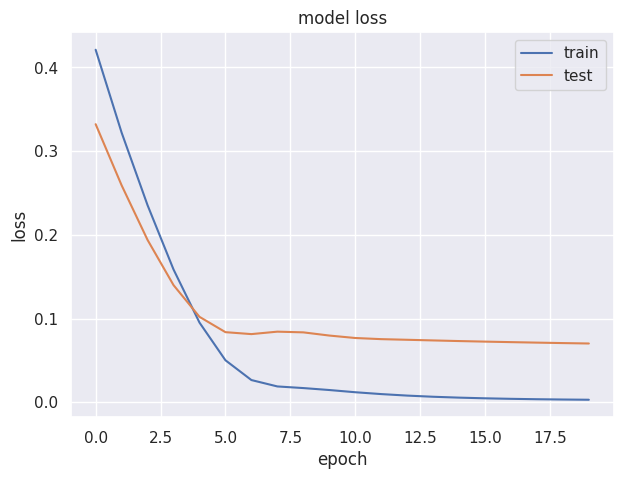

Test RMSE: 0.583


In [ ]:
# fit network
history = lstm_model1.fit(train_X, train_y, epochs=20, batch_size=6, validation_data=(test_X, test_y), verbose=1, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = lstm_model1.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -(dfvf1.shape[1]-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -(dfvf1.shape[1]-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
inv_yhat

array([87.14333848, 87.07480209, 87.22963055, 87.44123565, 87.58680016,
       87.32953762, 87.13390169, 86.99808881, 86.8517071 , 86.91451716,
       86.93134773, 86.89139819, 86.79901767, 86.75676056, 86.71093009])

In [ ]:
inv_y

array([87.7, 87.6, 87.9, 88. , 87.9, 87.8, 87.5, 87.3, 87. , 86.7, 86.4,
       86.2, 86. , 85.8, 85.8])

In [ ]:
test_data['LSTM_Predictions(Paper)'] = inv_yhat.tolist()
test_data.head()

,price,ARIMA_Predictions,LSTM_Predictions(Paper)
time,,,
2018-07,87.7,87.771918,87.143338
2018-08,87.6,87.779049,87.074802
2018-09,87.9,87.755902,87.229631
2018-10,88.0,87.661889,87.441236
2018-11,87.9,87.514527,87.586800


In [ ]:
lstm1_rmse = mean_squared_error(test_data['price'], test_data['LSTM_Predictions(Paper)'])**0.5
lstm1_mse = lstm1_rmse**2

print(f'LSTM1 MSE Error: {lstm1_mse}\nLSTM1 RMSE Error: {lstm1_rmse}')

LSTM1 MSE Error: 0.3402605942161771
LSTM1 RMSE Error: 0.5833186043802967


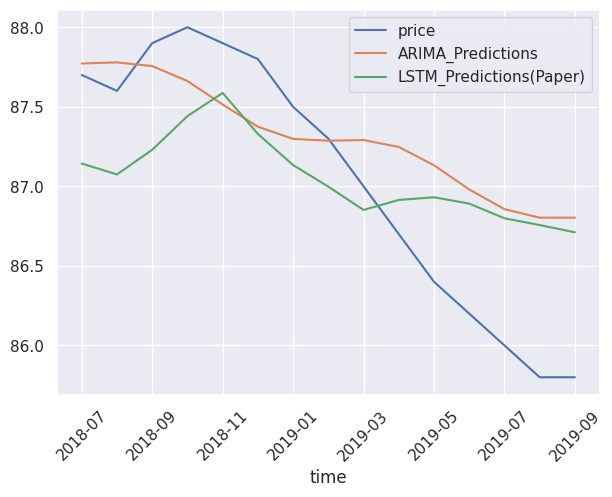

In [ ]:
test_data.plot(figsize = (7,5), legend=True)
plt.xticks(rotation=45)
plt.show()

## 2-2. LSTM (My Dataset)

In [ ]:
# My Dataset (use more features compared to the upper dataset)
dfvf2 = df1_1.copy()

In [ ]:
dfvf2 = dfvf2.set_index('time')
dfvf2.head()

,price,cofix_new,cpi,idx_manuf,jeonse,promissory,ppi,contract,unsold,unemploy,active_num,active_rate
time,,,,,,,,,,,,
2013-09,79.1,2.63,93.419,87.899,78.8,1311.8,104.71,45096,66110,2.7,26422,62.3
2013-10,79.5,2.62,93.134,98.506,79.6,1326.0,104.34,70827,64433,2.7,26522,62.5
2013-11,79.7,2.60,93.116,97.550,80.2,1331.1,104.13,50211,63709,2.6,26497,62.4
2013-12,79.9,2.66,93.229,98.593,80.7,1373.6,104.37,63647,61091,3.0,26023,61.2
2014-01,80.2,2.64,93.730,92.594,81.4,1367.8,104.65,36162,58576,3.4,25941,60.9


In [ ]:
# Split the data into training and testing sets
train_data2 = dfvf2[:len(dfvf2)-15]

# LSTM모델에서 t-1 시점 변수를 가져오기 위해 아래와 같이 split
test_data2 = dfvf2[len(dfvf2)-16:]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(train_data2)
scaled_train_data2 = scaler.transform(train_data2)

In [ ]:
scaler.fit(test_data2)
scaled_test_data2 = scaler.transform(test_data2)

In [ ]:
train_f2 = series_to_supervised(scaled_train_data2, 1, 1)
train_f2.drop(train_f2.columns[(dfvf2.shape[1]+1):], axis=1, inplace=True)

test_f2 = series_to_supervised(scaled_test_data2, 1, 1)
test_f2.drop(test_f2.columns[(dfvf2.shape[1]+1):], axis=1, inplace=True)

display(train_f2.head())
display(test_f2.head())

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var1(t)
1,0.000000,0.977778,0.051680,0.209040,0.000000,0.911279,0.990385,0.073677,1.000000,0.043478,0.214445,0.466667,0.044444
2,0.044444,0.970370,0.003070,0.708427,0.055944,0.924083,0.939560,0.244193,0.955888,0.043478,0.259028,0.533333,0.066667
3,0.066667,0.955556,0.000000,0.663418,0.097902,0.928681,0.910714,0.107574,0.936844,0.000000,0.247882,0.500000,0.088889
4,0.088889,1.000000,0.019273,0.712524,0.132867,0.967000,0.943681,0.196612,0.867980,0.173913,0.036558,0.100000,0.122222
5,0.122222,0.985185,0.104725,0.430085,0.181818,0.961771,0.982143,0.014473,0.801825,0.347826,0.000000,0.000000,0.155556


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var1(t)
1,0.909091,0.615385,0.115880,0.789481,1.000000,0.414013,0.264706,0.465703,0.659955,0.411765,0.647706,0.826087,0.863636
2,0.863636,0.557692,0.000000,0.820189,0.911765,0.628025,0.547059,0.570640,0.882268,0.411765,0.612844,0.739130,0.818182
3,0.818182,0.538462,0.534641,0.692972,0.823529,0.635669,0.823529,0.273824,0.725704,0.588235,0.535780,0.652174,0.954545
4,0.954545,0.596154,1.000000,0.552641,0.794118,0.625478,1.000000,0.528153,0.361208,0.352941,0.572477,0.695652,1.000000
5,1.000000,0.788462,0.889638,1.000000,0.764706,0.569427,0.788235,0.456288,0.341894,0.294118,0.557798,0.652174,0.954545


In [ ]:
train_f2 = train_f2.values
test_f2 = test_f2.values

train2_X, train2_y = train_f2[:, :-1], train_f2[:, -1]
test2_X, test2_y = test_f2[:, :-1], test_f2[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train2_X = train2_X.reshape((train2_X.shape[0], 1, train2_X.shape[1]))
test2_X = test2_X.reshape((test2_X.shape[0], 1, test2_X.shape[1]))

print(train2_X.shape, train2_y.shape, test2_X.shape, test2_y.shape)

(57, 1, 12) (57,) (15, 1, 12) (15,)


In [ ]:
lstm_model2 = Sequential()
lstm_model2.add(LSTM(100, activation='relu', input_shape=(train2_X.shape[1], train2_X.shape[2])))
#lstm_model2.add(Dropout(0.2))
lstm_model2.add(Dense(1))
lstm_model2.compile(optimizer='adam', loss='mse')

lstm_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               45200     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 45,301
Trainable params: 45,301
Non-trainable params: 0
_________________________________________________________________


Train on 57 samples, validate on 15 samples
Epoch 1/20
57/57 [==============================] - 0s 7ms/sample - loss: 0.3603 - val_loss: 0.2584
Epoch 2/20
57/57 [==============================] - 0s 545us/sample - loss: 0.2139 - val_loss: 0.1581
Epoch 3/20
57/57 [==============================] - 0s 541us/sample - loss: 0.1079 - val_loss: 0.0990
Epoch 4/20
57/57 [==============================] - 0s 586us/sample - loss: 0.0474 - val_loss: 0.0873
Epoch 5/20
57/57 [==============================] - 0s 626us/sample - loss: 0.0293 - val_loss: 0.0998
Epoch 6/20
57/57 [==============================] - 0s 513us/sample - loss: 0.0291 - val_loss: 0.1026
Epoch 7/20
57/57 [==============================] - 0s 631us/sample - loss: 0.0253 - val_loss: 0.0952
Epoch 8/20
57/57 [==============================] - 0s 556us/sample - loss: 0.0194 - val_loss: 0.0897
Epoch 9/20
57/57 [==============================] - 0s 603us/sample - loss: 0.0147 - val_loss: 0.0875
Epoch 10/20
57/57 [=====================

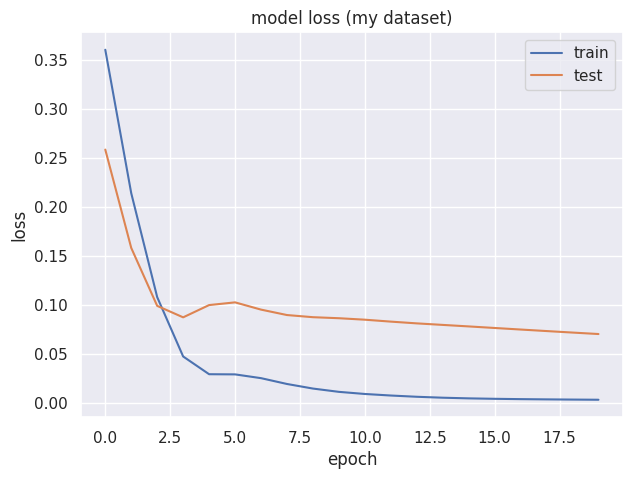

Test RMSE: 0.583


In [ ]:
# fit network
history2 = lstm_model2.fit(train2_X, train2_y, epochs=20, batch_size=6, validation_data=(test2_X, test2_y), verbose=1, shuffle=False)

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss (my dataset)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat2 = lstm_model2.predict(test2_X)
test2_X = test2_X.reshape((test2_X.shape[0], test2_X.shape[2]))

# invert scaling for forecast
inv_yhat2 = np.concatenate((yhat2, test2_X[:, -(dfvf2.shape[1]-1):]), axis=1)
inv_yhat2 = scaler.inverse_transform(inv_yhat2)
inv_yhat2 = inv_yhat2[:,0]

# invert scaling for actual
test2_y = test2_y.reshape((len(test2_y), 1))
inv_y2 = np.concatenate((test2_y, test2_X[:, -(dfvf2.shape[1]-1):]), axis=1)
inv_y2 = scaler.inverse_transform(inv_y2)
inv_y2 = inv_y2[:,0]

# calculate RMSE
rmse2 = np.sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Test RMSE: %.3f' % rmse2)

In [ ]:
inv_yhat2

array([87.51408504, 87.42336771, 87.3600806 , 87.5134783 , 87.51343333,
       87.29920156, 87.16251129, 86.84154516, 86.82474384, 87.16724011,
       87.17362956, 87.00118283, 86.99195402, 86.76512083, 86.41727446])

In [ ]:
inv_y2

array([87.7, 87.6, 87.9, 88. , 87.9, 87.8, 87.5, 87.3, 87. , 86.7, 86.4,
       86.2, 86. , 85.8, 85.8])

In [ ]:
test_data['LSTM_Predictions(My)'] = inv_yhat2.tolist()
test_data.head()

,price,ARIMA_Predictions,LSTM_Predictions(Paper),LSTM_Predictions(My)
time,,,,
2018-07,87.7,87.771918,87.143338,87.514085
2018-08,87.6,87.779049,87.074802,87.423368
2018-09,87.9,87.755902,87.229631,87.360081
2018-10,88.0,87.661889,87.441236,87.513478
2018-11,87.9,87.514527,87.586800,87.513433


In [ ]:
lstm2_rmse = mean_squared_error(test_data['price'], test_data['LSTM_Predictions(My)'])**0.5
lstm2_mse = lstm2_rmse**2

print(f'LSTM2 MSE Error: {lstm2_mse}\nLSTM2 RMSE Error: {lstm2_rmse}')

LSTM2 MSE Error: 0.34027836024713415
LSTM2 RMSE Error: 0.583333832592568


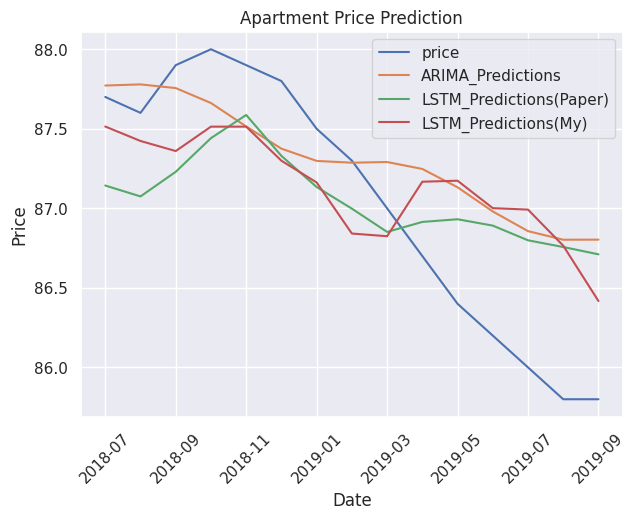

In [ ]:
test_data.plot(figsize = (7,5), legend=True)
plt.xticks(rotation=45)
plt.title('Apartment Price Prediction')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

In [ ]:
errors = pd.DataFrame({'MSE' : [arima_mse, lstm1_mse, lstm2_mse],
                       'RMSE' : [arima_rmse, lstm1_rmse, lstm2_rmse]},
                      index = ['ARIMA','LSTM(PAPER)','LSTM(MY)'])
errors

,MSE,RMSE
ARIMA,0.321218,0.566761
LSTM(PAPER),0.340261,0.583319
LSTM(MY),0.340278,0.583334


# SHAP

https://stackoverflow.com/questions/60690151/question-about-permutation-importance-on-lstm-keras

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.8 MB/s eta 0:00:00


In [ ]:
train2_Xr = train2_X.reshape((train2_X.shape[0], train2_X.shape[2]))
test2_Xr = test_f2[:, :-1]
test2_Xr = test2_Xr.reshape((test2_Xr.shape[0], 1, test2_Xr.shape[1]))
train2_yr = train2_y.reshape((len(train2_y), 1))

print(train2_Xr.shape)
print(train2_X.shape)
print(train2_yr.shape)

print(test2_X.shape)
print(test2_Xr.shape)
print(test2_y.shape)

(57, 12)
(57, 1, 12)
(57, 1)
(15, 12)
(15, 1, 12)
(15, 1)


In [ ]:
import shap
DE2 = shap.DeepExplainer(lstm_model2, train2_X) # X_train is 3d numpy.ndarray

In [ ]:
shap_values2 = DE2.shap_values(test2_Xr, check_additivity=False) # X_validate is 3d numpy.ndarray

In [ ]:
shap.initjs()

In [ ]:
print(shap_values2[0])

[[[ 8.54290108e-02 -1.86412106e-02 -5.20955664e-02  1.50142156e-02
    6.64932976e-02  2.44213072e-03  1.72531289e-02  2.05234280e-02
    2.61234742e-03 -4.01980184e-03  5.71187752e-03  1.07275514e-02]]

 [[ 7.13948799e-02 -1.36528493e-02 -6.95415334e-02  1.71832840e-02
    4.63986883e-02  8.81533762e-04  8.34627950e-04  3.68364245e-02
    1.67458663e-02 -3.83428394e-03  1.59928852e-03  5.36936940e-03]]

 [[ 5.73263425e-02 -1.16614788e-02  1.07830131e-02  7.44448562e-03
    2.61990683e-02 -6.02018728e-05 -1.74909500e-02 -1.03495876e-02
    6.89974680e-03  2.04067317e-02 -8.44940623e-03  4.00664118e-04]]

 [[ 1.00266433e-01 -1.61953485e-02  7.98638386e-02 -3.04865041e-03
    2.00683220e-02 -7.70012936e-04 -2.92678663e-02  3.01041460e-02
   -1.62802478e-02 -1.23499221e-02 -3.78539199e-03  2.56936410e-03]]

 [[ 1.14710699e-01 -3.34614712e-02  6.37790652e-02  3.06984187e-02
    1.33698555e-02  9.65049576e-04 -1.43907732e-02  1.88030376e-02
   -1.72599975e-02 -2.09337968e-02 -5.46152458e-03

In [ ]:
print(shap_values2[0].shape)
print(np.array(shap_values2).shape)

(15, 1, 12)
(1, 15, 1, 12)


In [ ]:
shapval2_0 = shap_values2[0]
print(shapval2_0.shape[2])

12


In [ ]:
shapval2_0r = shapval2_0.reshape(shapval2_0.shape[0],shapval2_0.shape[2])
shapval2_0r.shape

(15, 12)

In [ ]:
shapval2_0r = shapval2_0r.tolist()

df_shapval2_0r = pd.DataFrame(shapval2_0r, columns=dfvf2.columns, index=test_data.index)
df_shapval2_0r.rename(columns={'price':'price(t-1)'}, inplace=True)
df_shapval2_0r.head()

,price(t-1),cofix_new,cpi,idx_manuf,jeonse,promissory,ppi,contract,unsold,unemploy,active_num,active_rate
time,,,,,,,,,,,,
2018-07,0.085429,-0.018641,-0.052096,0.015014,0.066493,0.002442,0.017253,0.020523,0.002612,-0.004020,0.005712,0.010728
2018-08,0.071395,-0.013653,-0.069542,0.017183,0.046399,0.000882,0.000835,0.036836,0.016746,-0.003834,0.001599,0.005369
2018-09,0.057326,-0.011661,0.010783,0.007444,0.026199,-0.000060,-0.017491,-0.010350,0.006900,0.020407,-0.008449,0.000401
2018-10,0.100266,-0.016195,0.079864,-0.003049,0.020068,-0.000770,-0.029268,0.030104,-0.016280,-0.012350,-0.003785,0.002569
2018-11,0.114711,-0.033461,0.063779,0.030698,0.013370,0.000965,-0.014391,0.018803,-0.017260,-0.020934,-0.005462,0.000336


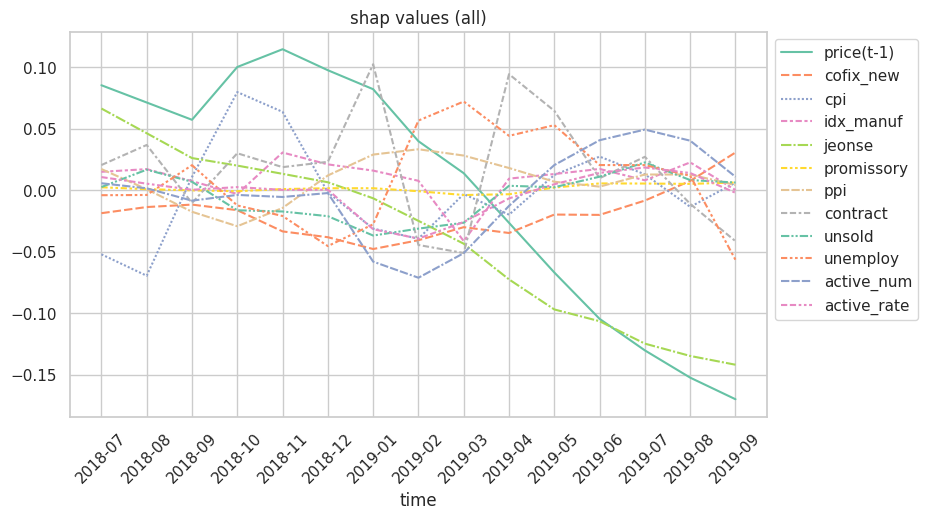

In [ ]:
sns.set(rc={'figure.figsize':(9,5)})
sns.set_style("whitegrid")

sns.lineplot(data=df_shapval2_0r, palette='Set2')
plt.xticks(rotation=45)
plt.title('shap values (all)')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.show()

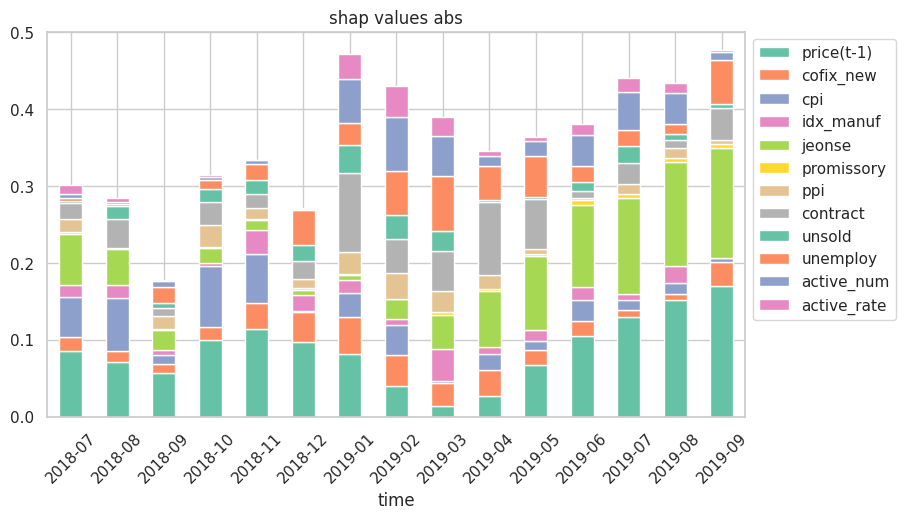

In [ ]:
sns.set(rc={'figure.figsize':(9,5)})
sns.set_style("whitegrid")

df_abs_shapval2_0r = df_shapval2_0r.abs()
colors = sns.color_palette('Set2',len(df_abs_shapval2_0r))

df_abs_shapval2_0r.plot(kind='bar', stacked=True, color=colors)
plt.xticks(rotation=45)
plt.title('shap values abs')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.show()

In [ ]:
colnum = len(df_shapval2_0r.columns)
abs_shapvals2 = []

for i in range(colnum) :
  abs_shapvals2.append(df_shapval2_0r.abs().iloc[:,i].values.sum())

In [ ]:
df_abs_shapvals2 = pd.DataFrame(abs_shapvals2, columns=['sum of abs shap'], index=df_shapval2_0r.columns)
df_abs_shapvals2.sort_values(by='sum of abs shap', ascending=False, inplace=True)
df_abs_shapvals2

,sum of abs shap
price(t-1),1.313384
jeonse,0.931354
contract,0.586401
unemploy,0.470213
cpi,0.443727
active_num,0.382194
cofix_new,0.371520
ppi,0.239773
idx_manuf,0.230473
unsold,0.229741


Text(0.5, 1.0, 'SHAP Summary')

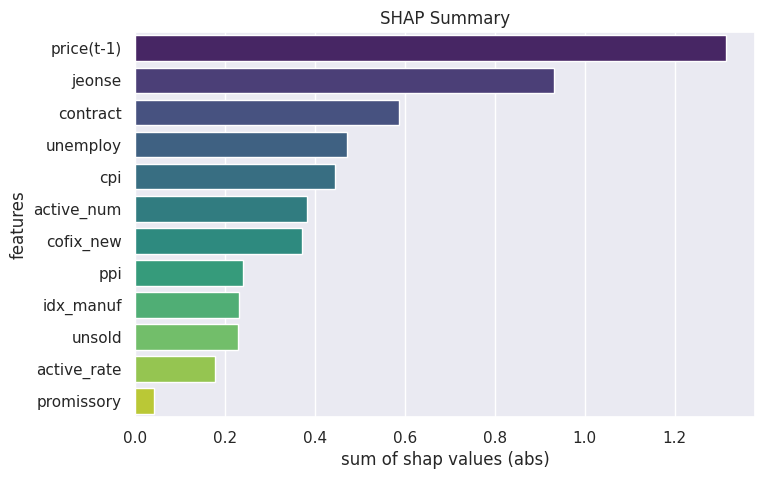

In [ ]:
sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(x=df_abs_shapvals2['sum of abs shap'], y=df_abs_shapvals2.index, palette='viridis')
plt.xlabel('sum of shap values (abs)')
plt.ylabel('features')
plt.title('SHAP Summary')

In [ ]:
#shap.summary_plot(shap_values[:,:,0].abs.sum(0),test2_Xr)
#    feature_names=list_of_your_columns_here,
#    max_display=50,
#    plot_type='bar')

# eli5 (LSTM에 적용 불가)
- https://stackoverflow.com/questions/60690151/question-about-permutation-importance-on-lstm-keras
- eli5's scikitlearn implementation for determining permutation importance can only process 2d arrays while keras' LSTM layers require 3d arrays. This error is a known issue but there appears to be no solution yet.

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
#from eli5.keras import explain_prediction

In [ ]:
perm = PermutationImportance(lstm_model2, scoring = 'accuracy', random_state = 42).fit(train2_X, train2_y)
eli5.show_weights(perm, top = 10)

ValueError: ignored